In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import pathlib

from torch import optim
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input,Activation
from tensorflow.keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_path = 'C:/Users/Gunhee/test/LASTPRO/CARTENADD'
data_dir = pathlib.Path(data_path)

In [3]:
data_dir

WindowsPath('C:/Users/Gunhee/test/LASTPRO/CARTENADD')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [5]:
image_count

26229

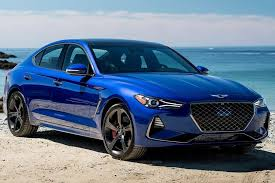

In [6]:
G70 = list(data_dir.glob('G70/*'))
PIL.Image.open(str(G70[0]))


In [7]:
batch_size = 32
img_height = 128
img_width = 128

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26229 files belonging to 10 classes.
Using 20984 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26229 files belonging to 10 classes.
Using 5245 files for validation.


In [10]:
#클래스가 정말 잘 분리되었는지를 확인
class_names = train_ds.class_names
print(class_names)
# 1배치 32  180x180의 3채널 컬러 확인
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['BOLT_EV', 'G70', 'G90', 'GV60', 'GV80', 'KorandoEmotion', 'Malibu', 'Torres', 'Traverse', 'Trax']
(32, 128, 128, 3)
(32,)


In [11]:
# 프로세스 튜닝
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# 데이터 전처리
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in [0,1]
print(np.min(first_image), np.max(first_image)) 

0.00014313344 1.0


In [23]:
# 모델 생성
num_classes = 10

model = Sequential()
model.add(Conv2D(128, (3, 3),input_shape=(img_height, img_width, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5)),
model.add(Conv2D(32, (3, 3), padding='same')),
model.add(Activation('relu')),
model.add(MaxPooling2D(pool_size=(2, 2))),
model.add(Dropout(0.5)),
model.add(Conv2D(64, (3, 3))),
model.add(MaxPooling2D(pool_size=(2, 2))),
model.add(Dropout(0.5)),
model.add(Conv2D(32, (3, 3), padding='same')),
model.add(Activation('relu')),
model.add(Dropout(0.5))

# 전결합층
model.add(Flatten())    # 벡터형태로 reshape
model.add(Dense(1024))   # 출력
model.add(Activation('relu'))
model.add(Dropout(0.5))

# model.add(Dense(128))   # 출력
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))
# 모델 구축하기
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='sparse_categorical_crossentropy',   # 최적화 함수 지정
    optimizer='RMSProp',
    metrics=['accuracy'])
# 모델 확인
#print(model.summary())

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 activation_5 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 activation_6 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

In [18]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
656/656 [==============================] - 688s 1s/step - loss: 3.9736 - accuracy: 0.1440 - val_loss: 2.2390 - val_accuracy: 0.1489
Epoch 2/10
656/656 [==============================] - 724s 1s/step - loss: 2.2534 - accuracy: 0.1472 - val_loss: 2.2366 - val_accuracy: 0.1489
Epoch 3/10
215/656 [========>.....................] - ETA: 8:15 - loss: 2.2528 - accuracy: 0.1503

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_3/max_pooling2d_6/MaxPool/MaxPoolGrad' defined at (most recent call last):
    File "C:\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Anaconda3\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Gunhee\AppData\Local\Temp\ipykernel_22496\3592753415.py", line 2, in <cell line: 2>
      history = model.fit(
    File "C:\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Anaconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "C:\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_3/max_pooling2d_6/MaxPool/MaxPoolGrad'
OOM when allocating tensor with shape[32,128,128,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/sequential_3/max_pooling2d_6/MaxPool/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_15975]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()